# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**
Данные геологоразведки трёх регионов находятся в 3 файлах:

id — уникальный идентификатор скважины;
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
product — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [ ]:
import pandas as pd
from IPython.display import display 
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format) 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV 
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression 
from scipy import stats as st 

In [ ]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv', sep=',')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv', sep=',')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv', sep=',')

In [ ]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.706,-0.498,1.221,105.280
1,2acmU,1.335,-0.340,4.365,73.038
2,409Wp,1.023,0.152,1.420,85.266
3,iJLyR,-0.032,0.139,2.979,168.621
4,Xdl7t,1.988,0.155,4.752,154.037


In [ ]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001,-8.276,-0.006,3.179
1,62mP7,14.272,-3.475,0.999,26.953
2,vyE1P,6.263,-5.948,5.001,134.766
3,KcrkZ,-13.081,-11.506,4.999,137.945
4,AHL4O,12.702,-8.147,5.004,134.766


In [ ]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.147,0.963,-0.829,27.759
1,WJtFt,0.263,0.270,-2.530,56.070
2,ovLUW,0.195,0.289,-5.586,62.872
3,q6cA6,2.236,-0.554,0.930,114.573
4,WPMUX,-0.516,1.716,5.899,149.601


In [ ]:
print(geo_data_0.info())
print(geo_data_1.info())
print(geo_data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column  

Все данные заполнены, пропусков нет

In [ ]:
geo_data_0.describe()
geo_data_1.describe()
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000,100000.000,100000.000,100000.000
mean,0.002,-0.002,2.495,95.000
std,1.732,1.730,3.473,44.750
min,-8.760,-7.084,-11.970,0.000
25%,-1.162,-1.175,0.130,59.450
50%,0.009,-0.009,2.484,94.926
75%,1.159,1.164,4.859,130.595
max,7.238,7.845,16.739,190.030


Столбцы с id нам не понадобятся, удалим их из датасетов

In [ ]:
geo_data_0 = geo_data_0.drop('id', axis=1)
geo_data_1 = geo_data_1.drop('id', axis=1)
geo_data_2 = geo_data_2.drop('id', axis=1)

**Вывод**

Предобработка данных не нужна, идем дальше 

## Обучение и проверка модели

Подготовим отдельную функцию для деления данных

In [ ]:
def prepare (geo_data_region):
    features = geo_data_region.drop('product', axis=1)
    target = geo_data_region['product']
    # разделим выборки в пропорции 25 к 75
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                                  test_size=0.25, random_state=12345)
    # проведем масштабирование
    numeric = ['f0', 'f1', 'f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])

    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    return features_train, features_valid, target_train, target_valid   

In [ ]:
# получим features и target для 3-х регионов
features_train_0, features_valid_0, target_train_0, target_valid_0 = prepare(geo_data_0)
features_train_1, features_valid_1, target_train_1, target_valid_1 = prepare(geo_data_1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = prepare(geo_data_2)
# проверим работу функции на одном из регионов
print(features_train_0.shape)
print(features_valid_0.shape)
print(target_train_0.shape)
print(target_valid_0.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


In [ ]:
features_train_0.describe()

,f0,f1,f2
count,75000.000,75000.000,75000.000
mean,0.000,-0.000,0.000
std,1.000,1.000,1.000
min,-2.186,-2.178,-3.891
25%,-0.658,-0.893,-0.680
50%,0.002,-0.001,0.004
75%,0.657,0.893,0.683
max,2.139,2.169,4.154


In [ ]:
def modeling(features_train, features_valid, target_train, target_valid):
    
    model = LinearRegression() # инициализируем модель LinearRegression
    model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
    predictions_valid = pd.Series(model.predict(features_valid)) # получаем предсказания модели на валидационной выборке

    rmse = mean_squared_error(target_valid, predictions_valid)**0.5 # считаем значение метрики RMSE на валидационной выборке
    mean_pred_pr = predictions_valid.mean()
    
    return predictions_valid, rmse, mean_pred_pr

In [ ]:
# получим данные для всех регионов
predictions_valid_0, rmse_0, mean_pred_pr_0 = modeling(features_train_0, features_valid_0, target_train_0, target_valid_0)
predictions_valid_1, rmse_1, mean_pred_pr_1 = modeling(features_train_1, features_valid_1, target_train_1, target_valid_1)
predictions_valid_2, rmse_2, mean_pred_pr_2 = modeling(features_train_2, features_valid_2, target_train_2, target_valid_2)
print('Для региона 1 средний запас предсказанного сырья составил {:.2f}, а RMSE модели {:.2f}'.format(mean_pred_pr_0, rmse_0))
print('Для региона 2 средний запас предсказанного сырья составил {:.2f}, а RMSE модели {:.2f}'.format(mean_pred_pr_1, rmse_1))
print('Для региона 3 средний запас предсказанного сырья составил {:.2f}, а RMSE модели {:.2f}'.format(mean_pred_pr_2, rmse_2))

Для региона 1 средний запас предсказанного сырья составил 92.59, а RMSE модели 37.58
Для региона 2 средний запас предсказанного сырья составил 68.73, а RMSE модели 0.89
Для региона 3 средний запас предсказанного сырья составил 94.97, а RMSE модели 40.03


In [ ]:
print('Для региона 1 истинный средний запас сырья равен {:.2f}'.format(target_valid_0.mean()))
print('Для региона 2 истинный средний запас сырья равен {:.2f}'.format(target_valid_1.mean()))
print('Для региона 3 истинный средний запас сырья равен {:.2f}'.format(target_valid_2.mean()))

Для региона 1 истинный средний запас сырья равен 92.08
Для региона 2 истинный средний запас сырья равен 68.72
Для региона 3 истинный средний запас сырья равен 94.88


**Вывод**

Все 3 модели предсказывают близкие к истинным значения, т.к. истинные средние запасы отличаются от предсказанных для каждой модели всего на несколько сотых.

Наилучшими прогнозными свойствами обладает модель 2, т.к. признак f2 имеет прямую зависимость с целевым признаком и определяет поведение модели. Предсказательные способности моделей для 1 и 3 регионов примерно одинаковые (согласно параметрам RMSE).

## Подготовка к расчёту прибыли

In [ ]:
EXPLORE_COUNT = 500 # количество точек для исследования
MINING_COUNT = 200 # количество точек для разработки
MINING_BUDGET = 10000 # бюджет на разработку скважин в регионе в млн. руб.
REVENUE_PER_BARREL = 0.45 # доход с 1 тыс баррель в млн. руб
LOSS_PROBABILITY = 0.025 # максимальная вероятность убытков
BOOTSTRAP_SAMPLES = 1000

Для расчета достаточного объема сырья для безубыточной разработки новой скважины необходимо:

Вычислить допустимые средние затраты на разработку одной скважины - разделить бюджет на количество скважин.
Вычислить какое количество в тыс. баррель необходимо для покрытия затрат на одну скважину.

In [ ]:
budget_per_borehole = MINING_BUDGET / MINING_COUNT # затраты на разработку одной скважины

# необходимый объем сырья для безубыточной разработки 1 скважины в тыс. баррелей
sufficient_product_volume = budget_per_borehole / REVENUE_PER_BARREL
print('Необходимый объем сырья для безубыточной разработки 1 скважины в тыс. баррелей {:.2f}'.format(sufficient_product_volume))

Необходимый объем сырья для безубыточной разработки 1 скважины в тыс. баррелей 111.11


Необходимый объем сырья для того, чтобы разработка скважины была окупаемой составил 111 тыс. баррелей. Средние значения запасов сырья для всех трех регионов ниже необходимого объема, что говорит о том, что при осуществлении разработки скважин, выбранных случайным образом, имеется высокая доля риска не окупить затраченный бюджет. Поэтому важно иметь модель, которая наиболее корректно предсказывала бы объем продукта в зависимости от известных факторов. В следующем этапе проверим работоспособность созданных ранее моделей для определения скважин с максимальными значениями предсказаний.

## Расчёт прибыли и рисков 

Произведем выбор скважин с максимальными значениями предсказаний. По условиям задачи для разработки берутся 200 лучших скважин. Для выбранных скважин найдем соответствующие им истинные значения и по ним проведем расчет прибыли. Добавим все в функцию, чтобы не дублировать код для каждого региона.

In [ ]:
def income_calc(target_valid, predictions_valid):
    pred_choice = predictions_valid.sort_values(ascending=False).head(200) # выбираем 200 скважин с максимальным объемом нефти
    target_choice = target_valid.reset_index(drop=True)[pred_choice.index] # определяем верные значения для отобранных 200 скважин
    income = target_choice.sum() * REVENUE_PER_BARREL # доход в млн. рублей с 200 скважин
    return income

In [ ]:
print('Прибыль в с 200 выбранных по предсказаниям модели скважин составит:')
print('для региона 1 - {:.3f} млн. руб.'.format(income_calc(target_valid_0, predictions_valid_0) - MINING_BUDGET))
print('для региона 2 - {:.3f} млн. руб.'.format(income_calc(target_valid_1, predictions_valid_1) - MINING_BUDGET))
print('для региона 3 - {:.3f} млн. руб.'.format(income_calc(target_valid_2, predictions_valid_2) - MINING_BUDGET))

Прибыль в с 200 выбранных по предсказаниям модели скважин составит:
для региона 1 - 3320.826 млн. руб.
для региона 2 - 2415.087 млн. руб.
для региона 3 - 2710.350 млн. руб.


Таким образом, мы получили очень высокие значения прибыли для каждого региона (от 2.4 млрд руб. до 3.2 млрд руб). НО! Данные значения мы можем получить, если проведем геолоразведку по 25 000 точкам, что повлечет за собой несоизмеримые с вложениями затраты. Согласно требованиям заказчика мы можем провести геолоразведку только по 500 точкам.

In [ ]:
def revenue (target_valid, predictions_valid, MINING_COUNT):
    pred_choice = predictions_valid.sort_values(ascending=False) # сортируем скважины по значениям их предсказаний
    
    # определяем верные значения для отобранных случайных скважин и берем только нужное количество
    target_choice = target_valid[pred_choice.index][:MINING_COUNT]
    income = target_choice.sum() * REVENUE_PER_BARREL # доход в млн. рублей
    return income

In [ ]:
# создадим ф-ю для применения для каждого региона
def income_distribution (predictions_valid, target_valid, BOOTSTRAP_SAMPLES, EXPLORE_COUNT):
    state = np.random.RandomState(12345)
    
    count = 0 # с помощью этого счетчика будем считать вероятность убытков в регионе

    values = [] # здесь будут все значения выручек для 1000 выборок
    
    for i in range(BOOTSTRAP_SAMPLES): # создаем 1000 выборок
    
        # у целевого признака валидац. выборки сбрасываем индексы и случайно выбираем нужное количество скважин
        target_subsample = target_valid.reset_index(drop=True).sample(EXPLORE_COUNT, replace=True, random_state=state)
        
        # из предсказаний выбираем строки соответствующие отобранным строкам в целевом признаке
        probs_subsample = predictions_valid[target_subsample.index]
        
        # считаем выручку для отобранных строк, но только для нужного количества скважин
        rev = revenue(target_subsample, probs_subsample, MINING_COUNT) - MINING_BUDGET
        # добавляем выручку в список выручек всех выборок
        values.append(rev)
        
        #проверяем не является выборка убыточной, если является, то увеличиваем счетчик
        if rev < 0:
            count +=1

    values = pd.Series(values)
    
    #посчитаем и выведем среднюю выручку
    mean = values.mean()
    print("Средняя выручка:", mean, 'млн рублей')
    
    # посчитаем и выведем 95-% доверительный интервал
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), np.std(values, ddof=1))
    print("95%-ый доверительный интервал:", confidence_interval)
    
    pvalue = 1. * count / BOOTSTRAP_SAMPLES
    if pvalue < LOSS_PROBABILITY:
        print("Вероятность убытков равна {:.2%} и является меньше допустимой, регион подходит по критериям".format(pvalue))
    else:
        print("Вероятность убытков равна {:.2%} и является больше допустимой, регион не подходит по критериям".format(pvalue))    
    
    # построим распределение выручки по региону
    plt.figure()
    _ = plt.hist(values,  bins=100)
    
    # левая граница доверительного интервала
    lower = values.quantile(0.025)
    # правая граница доверительного интервала
    higher = values.quantile(0.975)
    plt.title('Гистограмма распределения прибыли')
    plt.xlabel('Прибыль в млн. рублей')

Для первого региона при случайном выборе 500 скважин получаются следующие показатели
Средняя выручка: 425.9385269105927 млн рублей
95%-ый доверительный интервал: (-118.17308158673279, 970.0501354079182)
Вероятность убытков равна 6.00% и является больше допустимой, регион не подходит по критериям


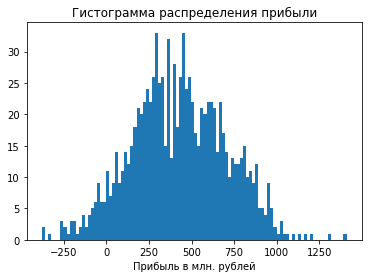

In [ ]:
print('Для первого региона при случайном выборе 500 скважин получаются следующие показатели')
income_distribution (predictions_valid_0, target_valid_0, BOOTSTRAP_SAMPLES, EXPLORE_COUNT)

Для второго региона при случайном выборе 500 скважин получаются следующие показатели
Средняя выручка: 515.2227734432902 млн рублей
95%-ый доверительный интервал: (85.11198847686433, 945.333558409716)
Вероятность убытков равна 1.00% и является меньше допустимой, регион подходит по критериям


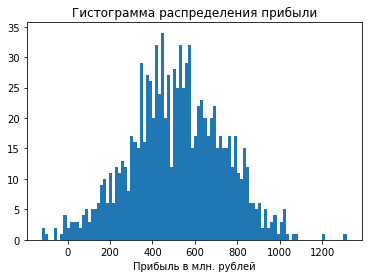

In [ ]:
print('Для второго региона при случайном выборе 500 скважин получаются следующие показатели')
income_distribution (predictions_valid_1, target_valid_1, BOOTSTRAP_SAMPLES, EXPLORE_COUNT)

Для третьего региона при случайном выборе 500 скважин получаются следующие показатели
Средняя выручка: 435.00836278275585 млн рублей
95%-ый доверительный интервал: (-120.12349557730545, 990.1402211428172)
Вероятность убытков равна 6.40% и является больше допустимой, регион не подходит по критериям


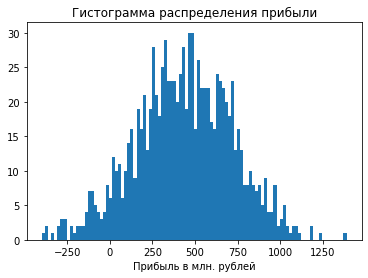

In [ ]:
print('Для третьего региона при случайном выборе 500 скважин получаются следующие показатели')
income_distribution (predictions_valid_2, target_valid_2, BOOTSTRAP_SAMPLES, EXPLORE_COUNT)

**Общий вывод**

Из полученных данных видно следующее:

При случайном выборе 500 скважин для проведения геолоразведки, потенциальная прибыль падает в среднем в 6 раз (с 3 млрд рублей до 0,5 млрд рублей) по сравнению с ситуацией, если бы мы проводили разведку для всего объема скважин. Рекомендуем заказчику определить объем вложений для проведения геолоразведки 1-й скважины и включения данного параметра в бизнес-модель.

Согласно расчитанной средней выручке все три региона являются прибыльными, средние чеки приняли значения: регион 1 - 426 млн. рублей, регион 2 - 515 млн. рублей, регион 3 - 435 млн. рублей.

1-ый и 3-й регионы обладают очень высокой вероятностью убытков (6 и 6.4 % соответственно), поэтому не проходят по критериям установленной бизнес-задачи (вероятность убытков должна быть меньше 2,5 %). 

Также эта ситуация хорошо описывается 95-% доврительным интервалом. Левая граница, которая отделяет 2.5 % данных для 1-го и 3-го регионов принимает отрицательное значение, что говорит о том, что более 2.5 % выборок имеют отрицательную прибыль.

**2-й регион** оказался лидирующим по всем показателям. Он обладает наибольшим средним чеком, а также единственный соответствует условию по минимальной вероятности убытков (левая граница 95-% доверительного интервала - положительная). В связи с чем для дальнейшей разработки заказчику предлагается принять только 2-й регион.